In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import product
from multiprocessing import Pool
from os import cpu_count
cores = cpu_count() # get the number of CPUs

df = pd.read_csv('wine.csv')

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color']
target = ['quality']

x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.2)
x_tr,x_va,y_tr,y_va = train_test_split(x_tr,y_tr,
                                       test_size = 0.5)
scaler = StandardScaler()
scaler.fit(x_tr)
x_tr_n = pd.DataFrame(scaler.transform(x_tr))
x_tr_n.columns = features
x_tr_n.index = x_tr.index
x_va_n = pd.DataFrame(scaler.transform(x_va))
x_va_n.columns = features
x_va_n.index = x_va.index

sklearn has KNN.

In [2]:
len(x_tr)

2598

In [3]:
from sklearn.neighbors import KNeighborsRegressor

In [4]:
knn = KNeighborsRegressor()
knn.fit(scaler.transform(x_tr),y_tr)
knn.score(scaler.transform(x_va),y_va)

0.29198702651490105

Notes on this algorithm: the default number of neighbors is 5 (and it can be changed with parameter n_neighbors). Their contributions are by default weighted equally, but this can be altered to account for distance with parameter weights = 'distance'.

How does it run so quickly? It uses $k$-D trees. Time out to discuss $k$-D trees on the whiteboard, including the nearest neighbor search algorithm.

scipy has KDTree. Let's fit one to some data, then see how lookup works.

In [5]:
from scipy.spatial import KDTree

In [6]:
np.random.seed(0)
data = []
for i in range(15):
    data.append((np.random.randint(-10,10),np.random.randint(-10,10)))
data

[(2, 5),
 (-10, -7),
 (-7, -3),
 (-1, 9),
 (8, -6),
 (-4, 2),
 (-9, -4),
 (-3, 4),
 (7, -5),
 (3, -2),
 (-1, 9),
 (6, 9),
 (-5, 5),
 (5, -10),
 (8, -7)]

In [9]:
kdt = KDTree(data)

In [12]:
# query the tree: req'd argument: the point to find tree points close to
# optional second argument: the number of results to return
kdt.query((8,-4),5)

(array([1.41421356, 2.        , 3.        , 5.38516481, 6.70820393]),
 array([ 8,  4, 14,  9, 13]))

In [16]:
np.linalg.norm(np.array((8,-4))-np.array(data[8]))

1.4142135623730951

In [17]:
# if we query a dataframe, do we get location by loc or iloc?
df_data = pd.DataFrame(data,index = range(10,25))
kdt = KDTree(data)
kdt.query(np.array([8,-4]))
# iloc it is.

(1.4142135623730951, 8)

We can use a $k$-D tree to index our data set.

In [19]:
kdt = KDTree(x_tr_n)

In [22]:
# quickly get the 5 nearest neighbors
kdt.query(x_va_n.iloc[4],5)

(array([0.13031612, 0.86551579, 0.90228691, 1.0777282 , 1.18245991]),
 array([1489, 2258, 2369, 1492, 1117]))

In [23]:
print(np.linalg.norm(x_va_n.iloc[4]-x_tr_n.iloc[1489]))
print(np.linalg.norm(x_va_n.iloc[4]-x_tr_n.iloc[2258]))
print(np.linalg.norm(x_va_n.iloc[4]-x_tr_n.iloc[2369]))
print(np.linalg.norm(x_va_n.iloc[4]-x_tr_n.iloc[1492]))
print(np.linalg.norm(x_va_n.iloc[4]-x_tr_n.iloc[1117]))

0.13031612161515846
0.8655157890430663
0.9022869133946052
1.0777281979362114
1.182459911290499


What we want is the qualities (y's) for the indices returned.

In [25]:
# print the indices of the five nearest neighbors (x_tr.iloc)
print(kdt.query(x_va.iloc[4],5)[1])

# print the qualities of the five nearest neighbors (y_tr.iloc)
print([y_tr['quality'].iloc[i] for i in kdt.query(x_va.iloc[4],5)[1]])

# get the average quality of the five nearest neighbors
print(np.mean([y_tr['quality'].iloc[i] for i in kdt.query(x_va.iloc[4],5)[1]]))

[ 453  356 1644 1628 2130]
[6, 5, 5, 6, 7]
5.8


We'll make a function which takes a row and returns the average quality of the k (default: 5) nearest neighbors.

In [ ]:
def predict_quality(row,k=5):
    neighbors = kdt.query(row,k)[1]
    return(np.mean([y_tr.iloc[ix] for ix in neighbors]))

In [29]:
%%timeit
kdt = KDTree(x_tr_n)

561 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%%timeit
preds = x_va_n.apply(predict_quality,axis=1)

538 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
x_tr.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
6489            6.1              0.34         0.29             2.2      0.036   
4580            8.5              0.23         0.28            11.1      0.033   
5885            6.0              0.20         0.26             6.8      0.049   
5546            6.1              0.30         0.32             2.2      0.042   
3222            7.0              0.14         0.49             5.9      0.053   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
6489                 25.0                 100.0  0.98938  3.06       0.44   
4580                 30.0                  97.0  0.99507  3.03       0.39   
5885                 22.0                  93.0  0.99280  3.15       0.42   
5546                 41.0                 142.0  0.98952  3.31       0.44   
3222                 22.0                 118.0  0.99540  3.36       0.36   

      alcohol  color  
6489     11.8      0  
4580     10.5      0  
5885     11.0      0  
5546     12.7      0  
3222      9.4      0

In [31]:
1 - np.sum((y_va-np.array(preds).reshape(-1,1))**2)/\
    np.sum((y_va-np.mean(y_va))**2)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


quality    0.291987
dtype: float64

The accuracy matches sklearn's knn, and we've fixed the speed.

Can we predict the wine color based on the other information?

In [33]:
df = pd.read_csv('wine.csv')
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']
target = ['color']

x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       test_size = 0.2)
x_tr,x_va,y_tr,y_va = train_test_split(x_tr,y_tr,
                                       test_size = 0.5)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [35]:
knn.fit(scaler.transform(x_tr),y_tr)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- quality
Feature names seen at fit time, yet now missing:
- color

  warnings.warn(message, FutureWarning)
/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [36]:
knn.score(scaler.transform(x_va),y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- quality
Feature names seen at fit time, yet now missing:
- color

  warnings.warn(message, FutureWarning)


0.9899961523662947

Apparently, we can!

In [42]:
df.corr()['color'].loc[features,].sort_values(key = lambda x:1-abs(x))

total sulfur dioxide   -0.700357
volatile acidity        0.653036
chlorides               0.512678
sulphates               0.487218
fixed acidity           0.486740
free sulfur dioxide    -0.471644
density                 0.390645
residual sugar         -0.348821
pH                      0.329129
citric acid            -0.187397
quality                -0.119323
alcohol                -0.032970
Name: color, dtype: float64

We can reliably predict the color in spite of the fact that the highest correlate with color has correlation -0.7 with it. It is instructive to view plots by color with on different 2D subspaces of the feature set:

In [43]:
df.color

0       1
1       1
2       1
3       1
4       1
       ..
6492    0
6493    0
6494    0
6495    0
6496    0
Name: color, Length: 6497, dtype: int64

In [44]:
colors = {1:'red',0:'blue'}

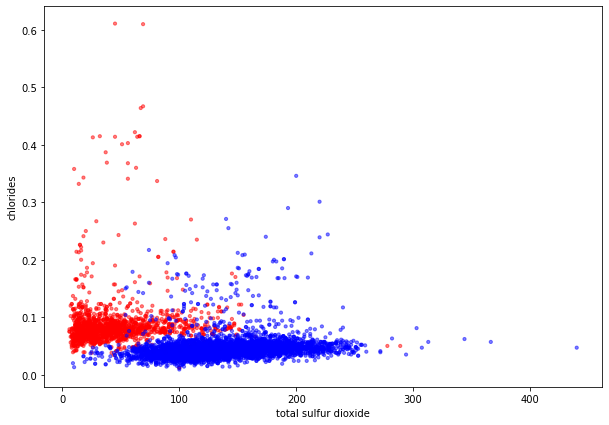

In [47]:
scatter_feats = []
scatter_feats.append('total sulfur dioxide') 
# scatter_feats.append('volatile acidity')
scatter_feats.append('chlorides')
# scatter_feats.append('sulphates')
# scatter_feats.append('fixed acidity')
# scatter_feats.append('free sulfur dioxide')
fig,ax = plt.subplots(figsize = (10,7))
ax.scatter(df[scatter_feats[0]],
            df[scatter_feats[1]],
            color = df.color.map(colors),
           alpha = 0.5,s = 10)
ax.set_ylabel(f'{scatter_feats[1]}')
ax.set_xlabel(f'{scatter_feats[0]}');

In [48]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  color  
0      9.4        5      1  
1      9.8        5      1  
2      9.8        5      1  
3      9.8        6      1  
4      9.4        5      1